In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import xarray as xr
import rasterio as rio
import rioxarray
import math, os
import pandas as pd
import geopandas as gpd
import xdem

### Let's make functions to see the distributions of our data among different slopes and  fcf. We'll just parse through our April 2022 Merced data

In [2]:
aso_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_merced_2022/ASO_50M_SD_Merced_20220428_clean.tif"
fcf_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_merced_2022/fcf_for_ASO_50M_SD_Merced_20220428_clean.nc"
dem_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_merced_2022/cop30_for_ASO_50M_SD_Merced_20220428_clean.nc"
aso_ds = xr.open_dataset(aso_path)
aso_ds = aso_ds.rename({'band_data': 'aso_sd'})
fcf_ds = xr.open_dataset(fcf_path).rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
fcf_ds = fcf_ds.rename({'__xarray_dataarray_variable__': 'fcf'})
dem_ds = xr.open_dataset(dem_path).rio.write_crs(aso_ds.rio.crs).rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
dem_ds = dem_ds.rename({'__xarray_dataarray_variable__': 'elevation'})
transform = (50, 0.0, dem_ds.isel(x=0, y=0).x.item(), 0.0, 50, dem_ds.isel(x=0, y=0).y.item())
dem = xdem.DEM.from_array(dem_ds.elevation.values, transform, crs=dem_ds.rio.crs)
dem_ds['slope'] = (('y', 'x'), xdem.terrain.slope(dem).data.data)
ds = xr.merge([aso_ds, fcf_ds, dem_ds], compat='override', join='override').squeeze()

/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/geoutils/raster/raster.py:1427: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


In [18]:
# subset to only include data within the 2nd and 98th percentiles and drop nulls
q02 = ds.aso_sd.quantile(0.02, dim=['x', 'y'])
q98 = ds.aso_sd.quantile(0.98, dim=['x', 'y'])
ds_subset = ds.where((ds.aso_sd >= q02) & (ds.aso_sd <= q98) & ds.aso_sd.notnull(), drop=True)

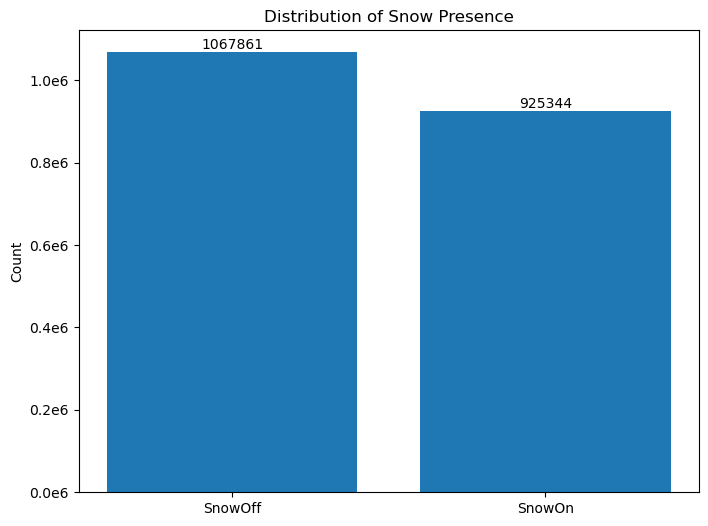

In [46]:
# Get counts for each condition
zero_snow = len(ds_subset.aso_sd.where(ds_subset.aso_sd == 0, drop=True).values.flatten())
nonzero_snow = len(ds_subset.aso_sd.where(ds_subset.aso_sd > 0, drop=True).values.flatten())

plt.figure(figsize=(8, 6))
plt.bar(['SnowOff', 'SnowOn'], [zero_snow, nonzero_snow])
plt.ylabel('Count')
plt.title('Distribution of Snow Presence')

# Format y-axis ticks in scientific notation
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}e6'))

# Add count labels on top of bars with regular numbers
for i, v in enumerate([zero_snow, nonzero_snow]):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/snowoff_snowon_bar.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# only get values where snowdepth is greater than 0
ds_subset_snowon = ds_subset.where(ds_subset.aso_sd > 0, drop=True)

---
Boxplots and violin plots

Note that this code below is super messy

/tmp/ipykernel_5225/626198979.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten())]


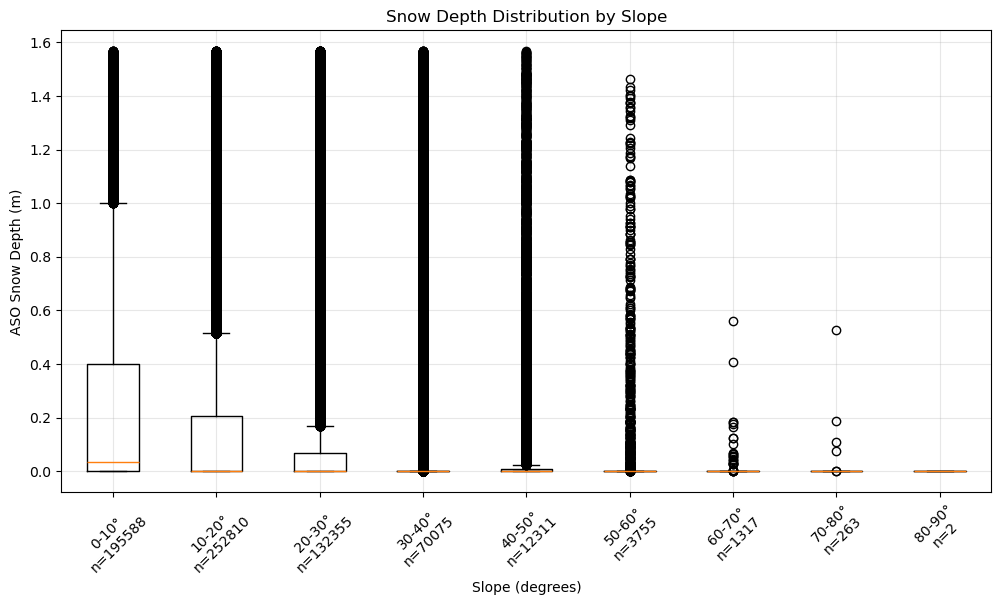

In [20]:
# slope for all
slope_bins = np.arange(0, 91, 10)
slope_labels = [f'{slope_bins[i]}-{slope_bins[i+1]}°\nn={len(ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten())])}' for i in range(len(slope_bins)-1)]
plt.figure(figsize=(12, 6))
plt.boxplot([ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten())]
             for i in range(len(slope_bins)-1)],
            labels=slope_labels)
plt.xlabel('Slope (degrees)')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Slope')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_5225/2898030166.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten())]


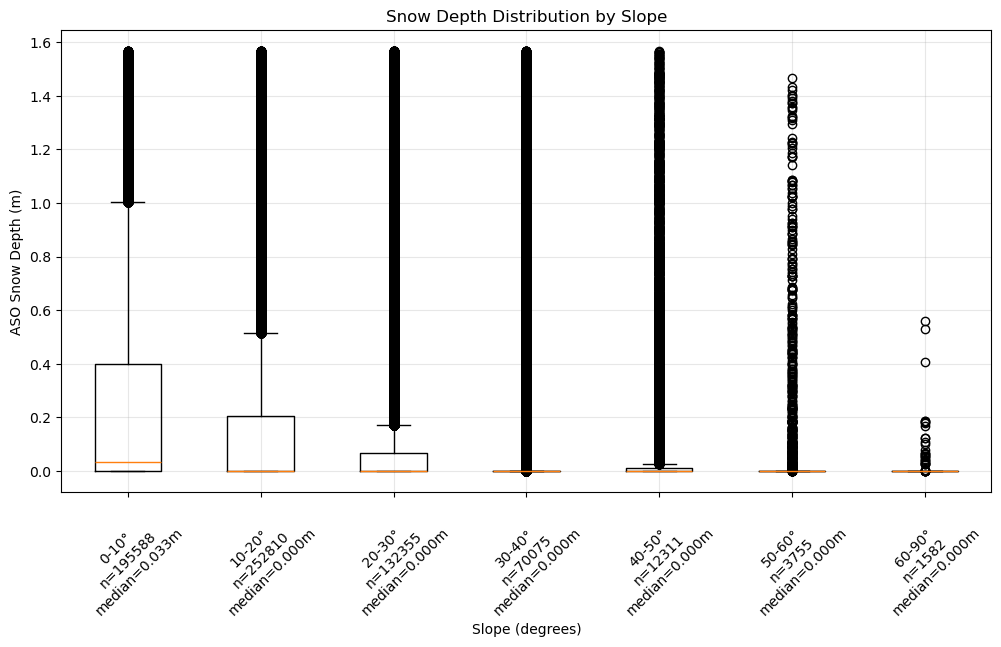

In [37]:
# slope for all
slope_bins = np.array([0, 10, 20, 30, 40, 50, 60, 90])

slope_labels = []
for i in range(len(slope_bins)-1):
    data = ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    median = np.median(data)
    slope_labels.append(f'{slope_bins[i]}-{slope_bins[i+1]}°\nn={len(data)}\nmedian={median:.3f}m')

plt.figure(figsize=(12, 6))

plt.boxplot([ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten())]
             for i in range(len(slope_bins)-1)],
            labels=slope_labels)

plt.xlabel('Slope (degrees)')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Slope')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/snowoff_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()

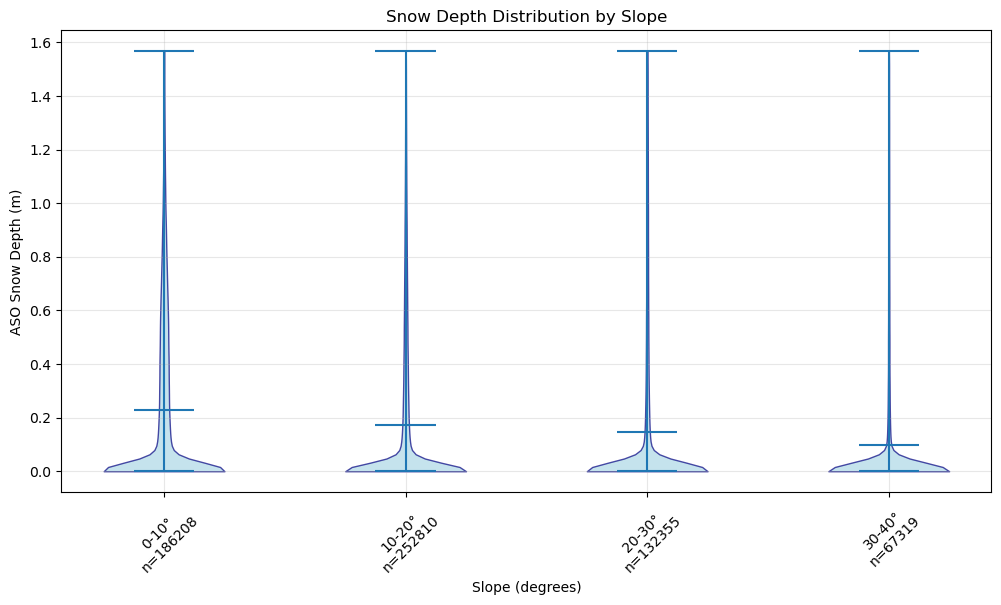

In [12]:
slope_bins = np.arange(0, 41, 10)

violin_data = []
slope_labels = []

for i in range(len(slope_bins)-1):
    data = ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    
    if len(data) > 0:
        violin_data.append(data)
        slope_labels.append(f'{slope_bins[i]}-{slope_bins[i+1]}°\nn={len(data)}')

plt.figure(figsize=(12, 6))
parts = plt.violinplot(violin_data, showmeans=True)

for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)
    pc.set_edgecolor('navy')

plt.xticks(range(1, len(violin_data) + 1), slope_labels, rotation=45)
plt.xlabel('Slope (degrees)')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Slope')
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_5225/2547130886.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten())]


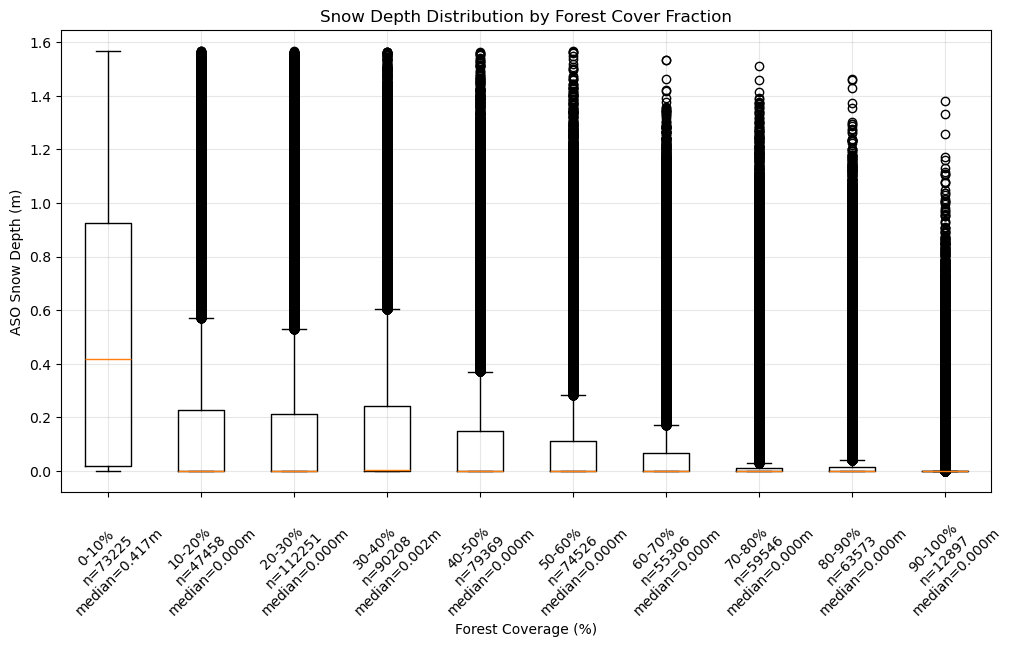

In [53]:
# fcf
fcf_bins = np.arange(0, 1.1, 0.1)

fcf_labels = []
for i in range(len(fcf_bins)-1):
    data = ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    median = np.median(data)
    fcf_labels.append(f'{int(fcf_bins[i]*100)}-{int(fcf_bins[i+1]*100)}%\nn={len(data)}\nmedian={median:.3f}m')

plt.figure(figsize=(12, 6))

plt.boxplot([ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten()[~np.isnan(ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten())]
             for i in range(len(fcf_bins)-1)],
            labels=fcf_labels)

plt.xlabel('Forest Coverage (%)')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Forest Cover Fraction')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/snowoff_fcf_boxplots.png", dpi=330, bbox_inches='tight')

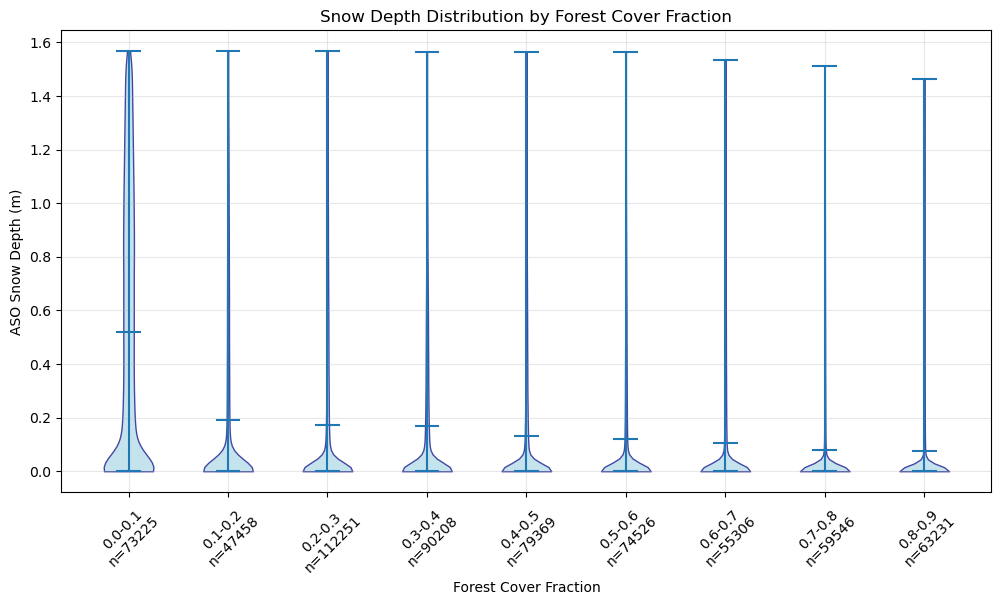

In [7]:
fcf_bins = np.arange(0, 1.1, 0.1)
violin_data = []
fcf_labels = []
for i in range(len(fcf_bins)-1):
    data = ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:  # Only include bins with data
        violin_data.append(data)
        fcf_labels.append(f'{fcf_bins[i]:.1f}-{fcf_bins[i+1]:.1f}\nn={len(data)}')
plt.figure(figsize=(12, 6))
parts = plt.violinplot(violin_data, showmeans=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)
    pc.set_edgecolor('navy')
plt.xticks(range(1, len(violin_data) + 1), fcf_labels, rotation=45)
plt.xlabel('Forest Cover Fraction')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Forest Cover Fraction')
plt.grid(True, alpha=0.3)

/tmp/ipykernel_5225/533038789.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) &


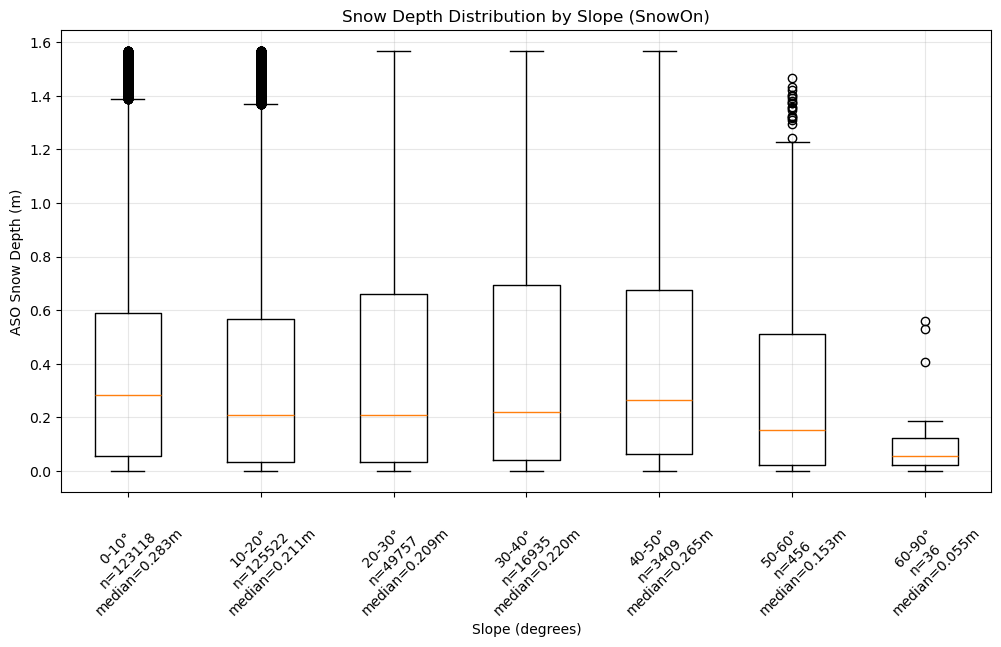

In [38]:
# slope for snowon
slope_bins = np.array([0, 10, 20, 30, 40, 50, 60, 90])
slope_labels = []
for i in range(len(slope_bins)-1):
    data = ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    median = np.median(data)
    slope_labels.append(f'{slope_bins[i]}-{slope_bins[i+1]}°\nn={len(data)}\nmedian={median:.3f}m')
plt.figure(figsize=(12, 6))
plt.boxplot([ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & 
                                           (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten()[~np.isnan(ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & 
                                                                                                                                                (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten())]
             for i in range(len(slope_bins)-1)],
            labels=slope_labels)
plt.xlabel('Slope (degrees)')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Slope (SnowOn)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/snowon_slope_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()

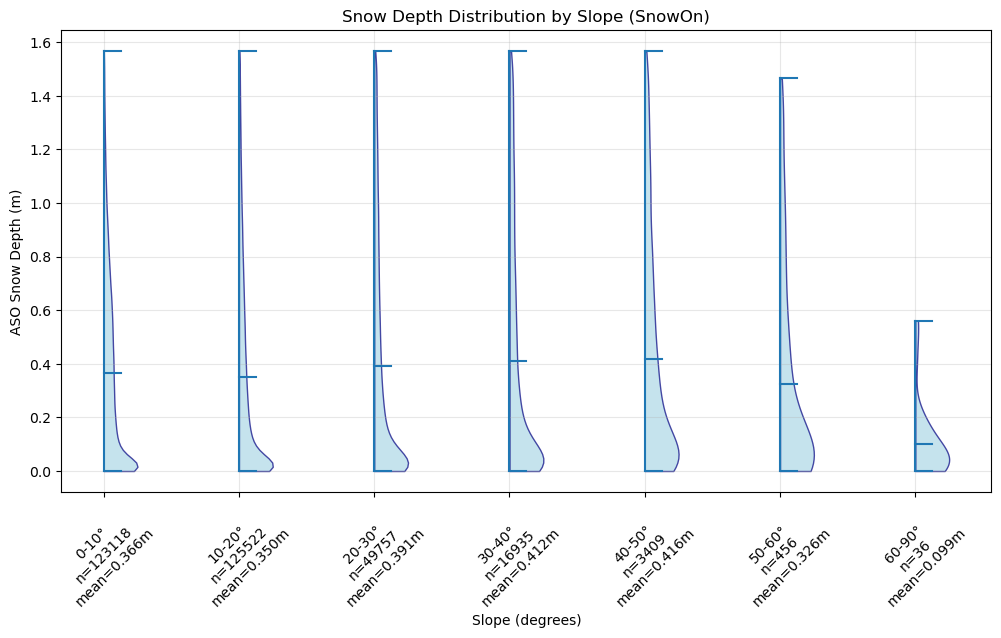

In [39]:
slope_bins = np.array([0, 10, 20, 30, 40, 50, 60, 90])

violin_data = []
slope_labels = []

for i in range(len(slope_bins)-1):
    data = ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    
    if len(data) > 0:
        violin_data.append(data)
        mean = np.mean(data)
        slope_labels.append(f'{slope_bins[i]}-{slope_bins[i+1]}°\nn={len(data)}\nmean={mean:.3f}m')

plt.figure(figsize=(12, 6))
parts = plt.violinplot(violin_data, showmeans=True, side='high')

for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)
    pc.set_edgecolor('navy')

plt.xticks(range(1, len(violin_data) + 1), slope_labels, rotation=45)
plt.xlabel('Slope (degrees)')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Slope (SnowOn)')
plt.grid(True, alpha=0.3)
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/snowon_slope_violin.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_5225/2297697872.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten()[~np.isnan(ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten())]


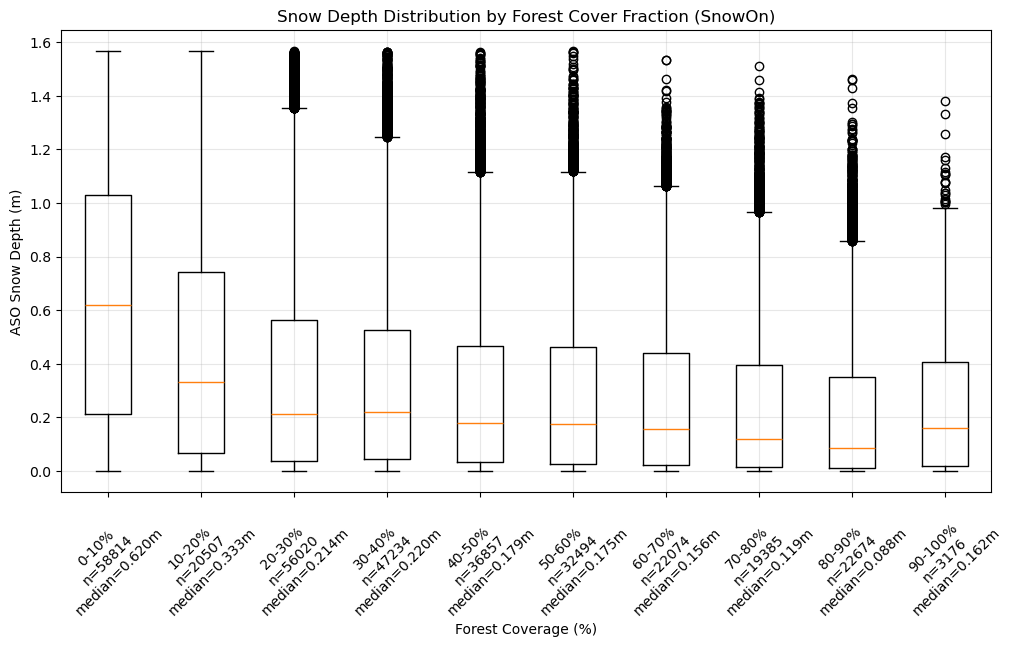

In [54]:
# fcf snowon
fcf_bins = np.arange(0, 1.1, 0.1)

fcf_labels = []
for i in range(len(fcf_bins)-1):
    data = ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    median = np.median(data)
    fcf_labels.append(f'{int(fcf_bins[i]*100)}-{int(fcf_bins[i+1]*100)}%\nn={len(data)}\nmedian={median:.3f}m')

plt.figure(figsize=(12, 6))

plt.boxplot([ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten()[~np.isnan(ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten())]
             for i in range(len(fcf_bins)-1)],
            labels=fcf_labels)

plt.xlabel('Forest Coverage (%)')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Forest Cover Fraction (SnowOn)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/snowon_fcf_boxplots.png", dpi=330, bbox_inches='tight')

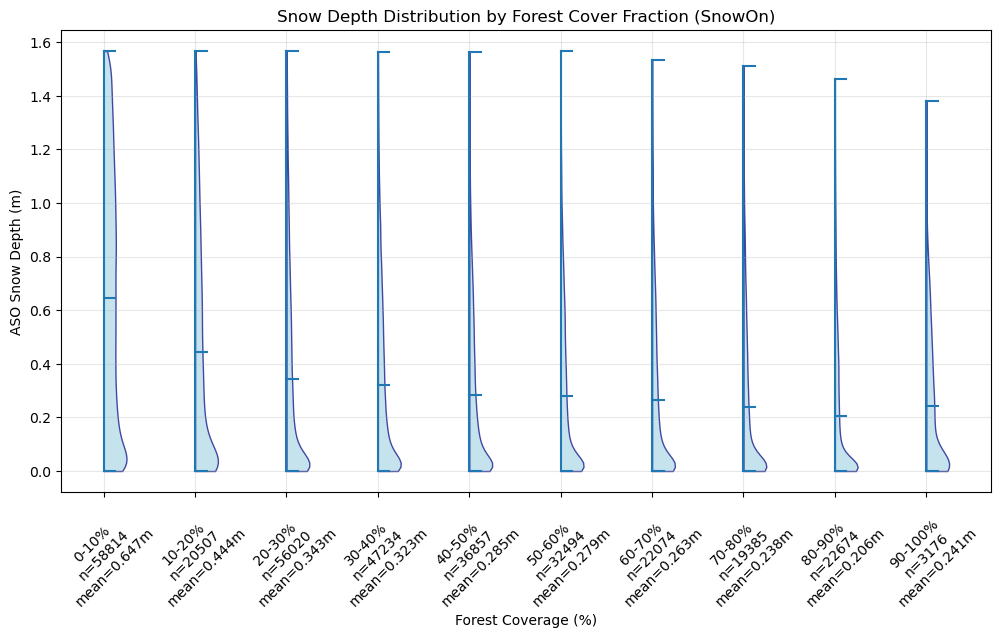

In [56]:
# fcf snowon
fcf_bins = np.arange(0, 1.1, 0.1)

violin_data = []
fcf_labels = []

for i in range(len(fcf_bins)-1):
    data = ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    
    if len(data) > 0:
        violin_data.append(data)
        mean = np.mean(data)
        fcf_labels.append(f'{int(fcf_bins[i]*100)}-{int(fcf_bins[i+1]*100)}%\nn={len(data)}\nmean={mean:.3f}m')

plt.figure(figsize=(12, 6))
parts = plt.violinplot(violin_data, showmeans=True, side='high')

for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)
    pc.set_edgecolor('navy')

plt.xticks(range(1, len(violin_data) + 1), fcf_labels, rotation=45)
plt.xlabel('Forest Coverage (%)')
plt.ylabel('ASO Snow Depth (m)')
plt.title('Snow Depth Distribution by Forest Cover Fraction (SnowOn)')
plt.grid(True, alpha=0.3)
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/snowon_fcf_violin.png", dpi=330, bbox_inches='tight')
plt.show()

---
Maps

In [ ]:
#aso_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_merced_2022/ASO_50M_SD_Merced_20220428_clean.tif"
#fcf_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_merced_2022/fcf_for_ASO_50M_SD_Merced_20220428_clean.nc"
#dem_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_merced_2022/cop30_for_ASO_50M_SD_Merced_20220428_clean.nc"
#aso_ds = xr.open_dataset(aso_path)
#aso_ds = aso_ds.rename({'band_data': 'aso_sd'})
#fcf_ds = xr.open_dataset(fcf_path).rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
#fcf_ds = fcf_ds.rename({'__xarray_dataarray_variable__': 'fcf'})
#dem_ds = xr.open_dataset(dem_path).rio.write_crs(aso_ds.rio.crs).rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
#dem_ds = dem_ds.rename({'__xarray_dataarray_variable__': 'elevation'})
#transform = (50, 0.0, dem_ds.isel(x=0, y=0).x.item(), 0.0, 50, dem_ds.isel(x=0, y=0).y.item())
#dem = xdem.DEM.from_array(dem_ds.elevation.values, transform, crs=dem_ds.rio.crs)
#dem_ds['slope'] = (('y', 'x'), xdem.terrain.slope(dem).data.data)
#ds = xr.merge([aso_ds, fcf_ds, dem_ds], compat='override', join='override').squeeze()

In [121]:
ds_subset_p.rio.crs

CRS.from_epsg(3857)

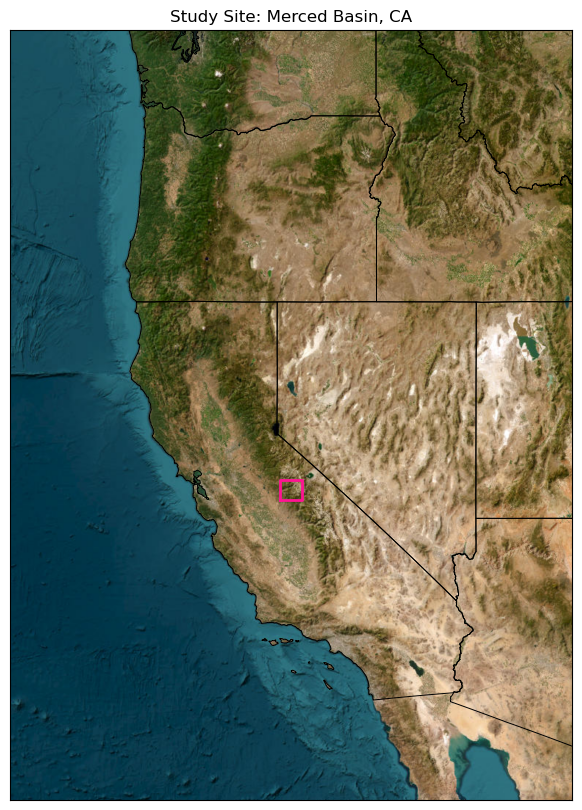

In [130]:
import contextily as ctx
fig, ax = plt.subplots(figsize=(8,10))
states = gpd.read_file("/mnt/c/Users/JackE/uw/STV/data/cb_2018_us_state_5m")
states.to_crs(3857).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.7)
ds_subset_p = ds_subset.rio.reproject(3857)
# Get min/max coordinates
lon_min = ds_subset_p.x.min().values
lon_max = ds_subset_p.x.max().values
lat_min = ds_subset_p.y.min().values
lat_max = ds_subset_p.y.max().values
# Create bbox as [minx, miny, maxx, maxy]
bbox = [lon_min, lat_min, lon_max, lat_max]
# Plot the bounding box
ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min], 
        [lat_min, lat_min, lat_max, lat_max, lat_min], 
        'deeppink', linewidth=2)
ax.set_xlim(lon_min-900000, lon_max+900000)
ax.set_ylim(lat_min-1000000, lat_max+1500000)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=3857, attribution=False)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Study Site: Merced Basin, CA')
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/study_site.png", dpi=330, bbox_inches='tight')
plt.show()

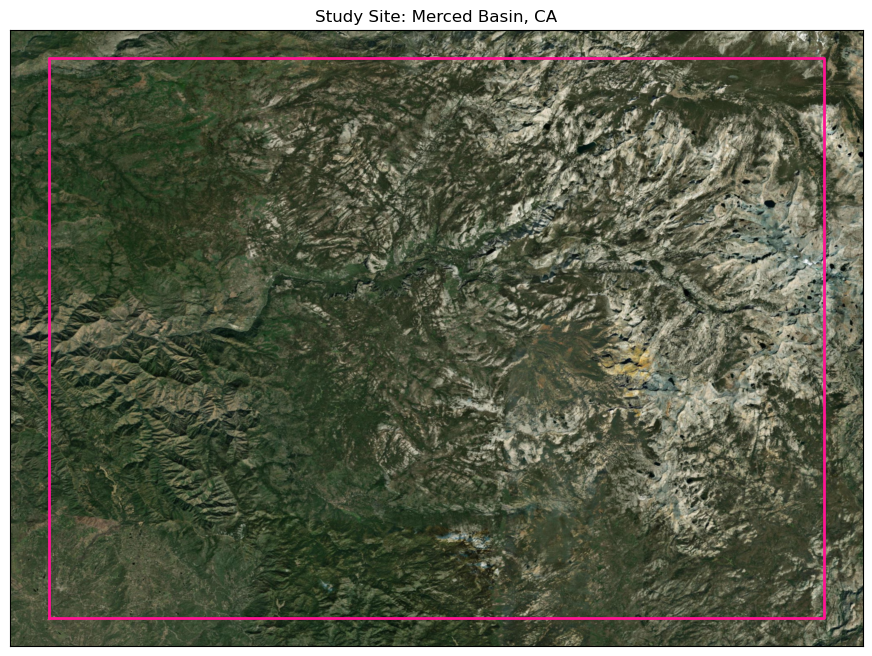

In [132]:
fig, ax = plt.subplots(figsize=(11,8))
# Get min/max coordinates
lon_min = ds_subset.x.min().values
lon_max = ds_subset.x.max().values
lat_min = ds_subset.y.min().values
lat_max = ds_subset.y.max().values
# Create bbox as [minx, miny, maxx, maxy]
bbox = [lon_min, lat_min, lon_max, lat_max]
# Plot the bounding box
ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min], 
        [lat_min, lat_min, lat_max, lat_max, lat_min], 
        'deeppink', linewidth=2)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ds_subset.rio.crs, attribution=False, zoom=12)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Study Site: Merced Basin, CA')
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/study_site_zoom.png", dpi=330, bbox_inches='tight')
plt.show()

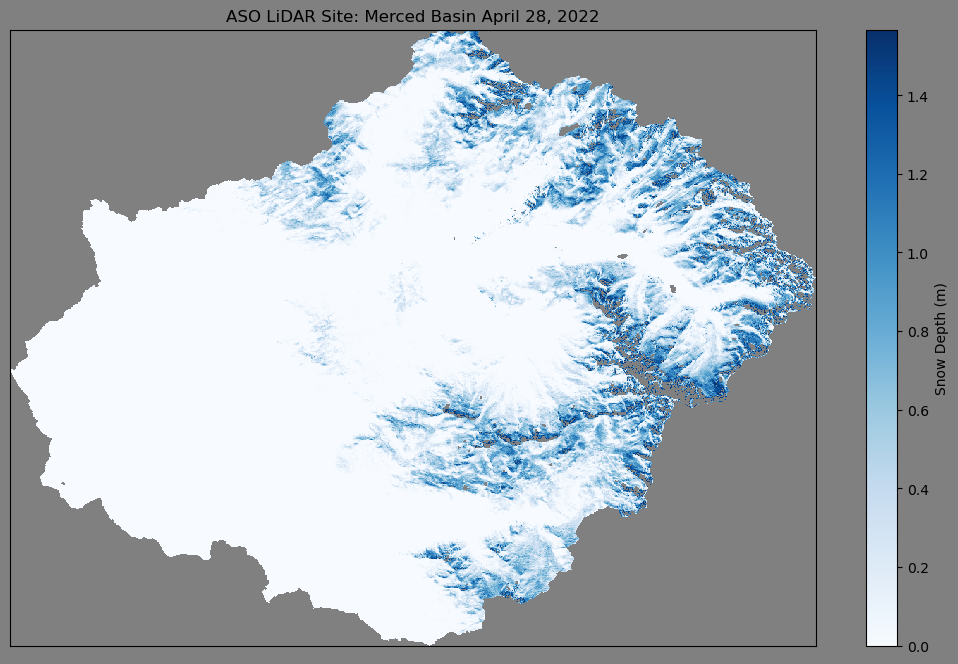

In [76]:
fig, ax = plt.subplots(figsize=(13,8))
ax.set_facecolor('#808080')
fig.set_facecolor('#808080')
cbar = ds_subset.aso_sd.plot(ax=ax, cmap='Blues')
plt.title('ASO LiDAR Site: Merced Basin April 28, 2022')
cbar.colorbar.set_label('Snow Depth (m)')
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/aso_sd_map.png", dpi=370, bbox_inches='tight')
plt.show()

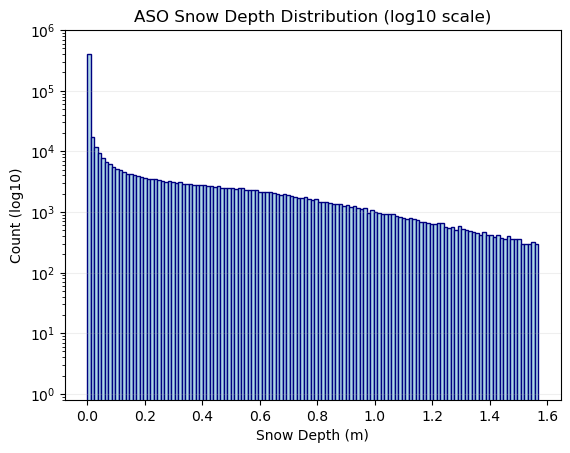

In [96]:
sd_data = ds_subset.aso_sd.values.flatten()
sd_data = sd_data[~np.isnan(sd_data)]

plt.hist(sd_data, bins=129, color='lightblue', edgecolor='navy')
plt.yscale('log')
plt.ylim(0.8, 1e6)  # Setting lower limit below 1 to show bars at 10^0
plt.ylabel('Count (log10)')
plt.xlabel('Snow Depth (m)')
plt.grid(True, which='major', axis='y', linestyle='-', alpha=0.2)
plt.title("ASO Snow Depth Distribution (log10 scale)")
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/aso_sd_hist.png", dpi=300, bbox_inches='tight')
plt.show()

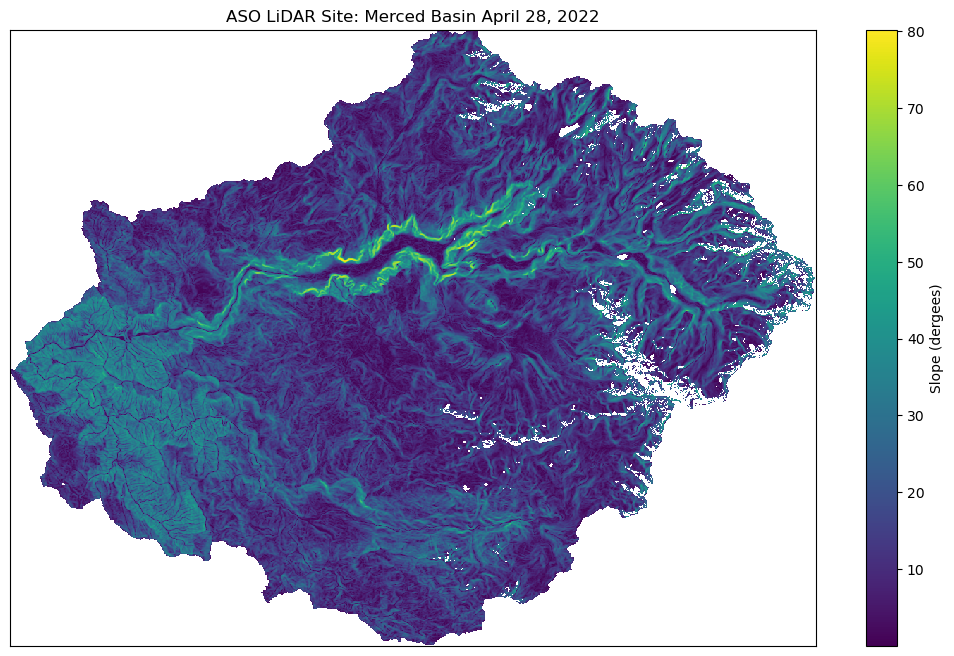

In [78]:
fig, ax = plt.subplots(figsize=(13,8))
cbar = ds_subset.slope.plot(ax=ax, cmap='viridis')
plt.title('ASO LiDAR Site: Merced Basin April 28, 2022')
cbar.colorbar.set_label('Slope (dergees)')
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/aso_slope_map.png", dpi=370, bbox_inches='tight')
plt.show()

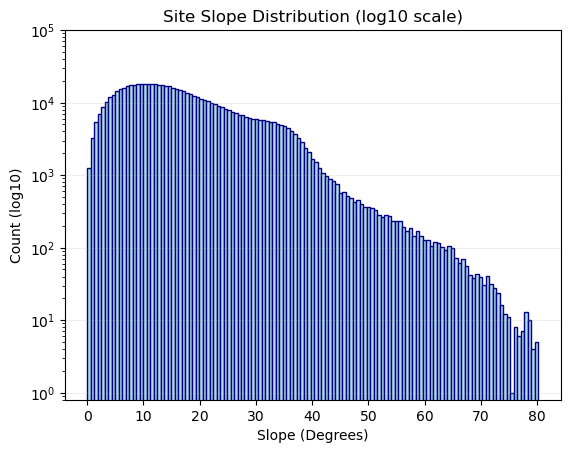

In [102]:
slope_data = ds_subset.slope.values.flatten()
slope_data = slope_data[~np.isnan(slope_data)]

plt.hist(slope_data, bins=129, color='lightblue', edgecolor='navy')
plt.yscale('log')
plt.ylim(0.8, 1e5)
plt.ylabel('Count (log10)')
plt.xlabel('Slope (Degrees)')
plt.grid(True, which='major', axis='y', linestyle='-', alpha=0.2)
plt.title("Site Slope Distribution (log10 scale)")
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/slope_hist.png", dpi=300, bbox_inches='tight')
plt.show()

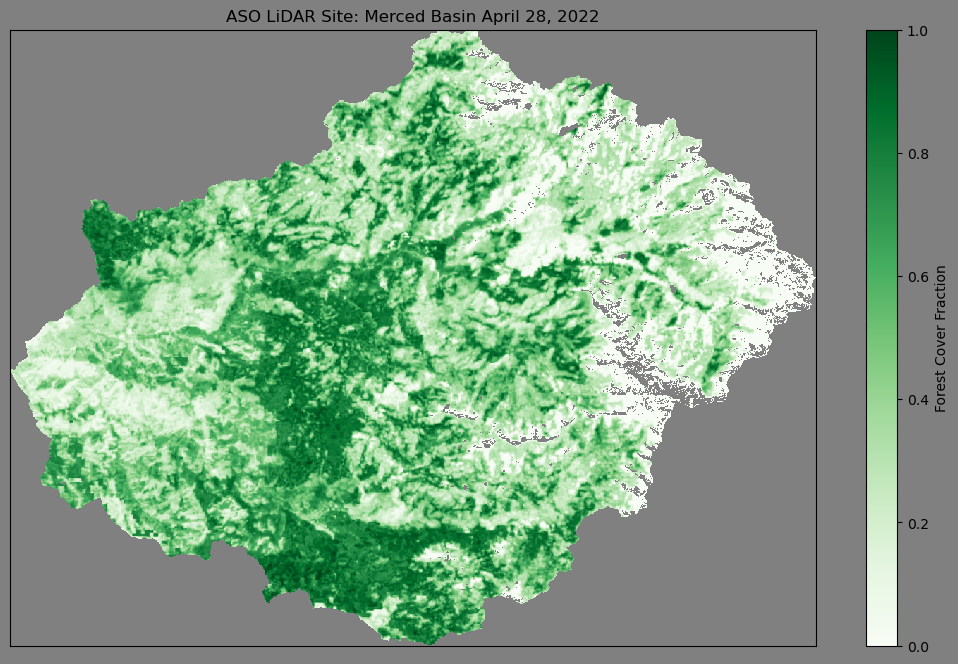

In [81]:
fig, ax = plt.subplots(figsize=(13,8))
ax.set_facecolor('#808080')
fig.set_facecolor('#808080')
cbar = ds_subset.fcf.plot(ax=ax, cmap='Greens')
plt.title('ASO LiDAR Site: Merced Basin April 28, 2022')
cbar.colorbar.set_label('Forest Cover Fraction')
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/aso_fcf_map.png", dpi=370, bbox_inches='tight')
plt.show()

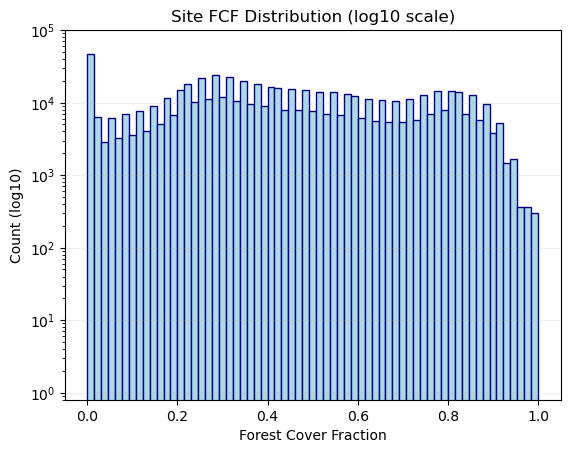

In [110]:
fcf_data = ds_subset.fcf.values.flatten()
fcf_data = fcf_data[~np.isnan(fcf_data)]

plt.hist(fcf_data, bins=65, color='lightblue', edgecolor='navy')
plt.yscale('log')
plt.ylim(0.8, 1e5)
plt.ylabel('Count (log10)')
plt.xlabel('Forest Cover Fraction')
plt.grid(True, which='major', axis='y', linestyle='-', alpha=0.2)
plt.title("Site FCF Distribution (log10 scale)")
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/fcf_hist_64.png", dpi=300, bbox_inches='tight')
plt.show()

---
Stats tests

In [138]:
slope_groups = []
slope_bins = np.array([0, 10, 20, 30, 40, 50, 60, 90])
for i in range(len(slope_bins)-1):
    data = ds_subset_snowon.aso_sd.where((ds_subset_snowon.slope >= slope_bins[i]) & (ds_subset_snowon.slope < slope_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    slope_groups.append(data)
fcf_groups = []
fcf_bins = np.arange(0, 1.1, 0.1)
for i in range(len(fcf_bins)-1):
    data = ds_subset_snowon.aso_sd.where((ds_subset_snowon.fcf >= fcf_bins[i]) & (ds_subset_snowon.fcf < fcf_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    fcf_groups.append(data)

In [141]:
from scipy.stats import fligner
slope_stat, slope_p_value = fligner(*slope_groups)
print("Slope:")
print(f"Statistic: {slope_stat}, p-value: {slope_p_value}")
fcf_stat, fcf_p_value = fligner(*fcf_groups)
print("FCF:")
print(f"Statistic: {fcf_stat}, p-value: {fcf_p_value}")

Slope:
Statistic: 1130.3146325898483, p-value: 5.7562776414816925e-241
FCF:
Statistic: 29593.267823729504, p-value: 0.0


In [143]:
# Compact single-line output
print(f"Slope - Statistic: {slope_stat:.3f}, p-value: {slope_p_value:.3e}")
print(f"FCF - Statistic: {fcf_stat:.3f}, p-value: {fcf_p_value:.3e}")
# Or as a formatted table using pandas
import pandas as pd
results_df = pd.DataFrame({
    'Test': ['Slope', 'FCF'],
    'Test-statistic': [slope_stat, fcf_stat],
    'p-value': [slope_p_value, fcf_p_value]
})
display(results_df)

Slope - Statistic: 1130.315, p-value: 5.756e-241
FCF - Statistic: 29593.268, p-value: 0.000e+00


Test  Test-statistic        p-value
0  Slope     1130.314633  5.756278e-241
1    FCF    29593.267824   0.000000e+00

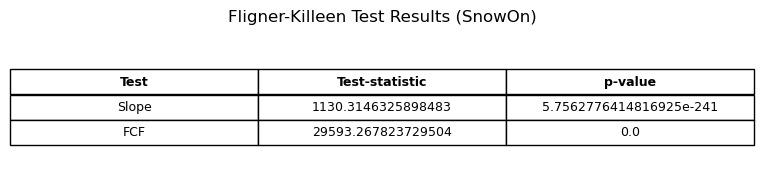

In [149]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values,
                colLabels=results_df.columns,
                cellLoc='center',
                loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
# Make headers bold
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')
ax.set_title("Fligner-Killeen Test Results (SnowOn)");
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/fk_table_snowon.png', 
            bbox_inches='tight',
            dpi=300,
            transparent=True)

Slope:
Statistic: 73867.12981783327, p-value: 0.0
FCF:
Statistic: 119404.68172954721, p-value: 0.0


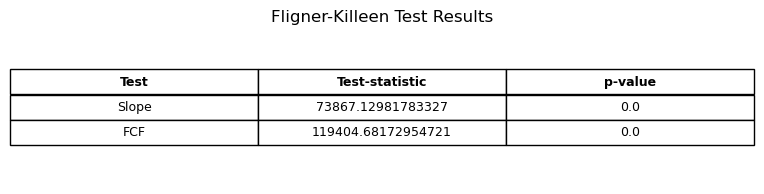

In [152]:
slope_groups = []
slope_bins = np.array([0, 10, 20, 30, 40, 50, 60, 90])
for i in range(len(slope_bins)-1):
    data = ds_subset.aso_sd.where((ds_subset.slope >= slope_bins[i]) & (ds_subset.slope < slope_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    slope_groups.append(data)
fcf_groups = []
fcf_bins = np.arange(0, 1.1, 0.1)
for i in range(len(fcf_bins)-1):
    data = ds_subset.aso_sd.where((ds_subset.fcf >= fcf_bins[i]) & (ds_subset.fcf < fcf_bins[i+1])).values.flatten()
    data = data[~np.isnan(data)]
    fcf_groups.append(data)
from scipy.stats import fligner
slope_stat, slope_p_value = fligner(*slope_groups)
print("Slope:")
print(f"Statistic: {slope_stat}, p-value: {slope_p_value}")
fcf_stat, fcf_p_value = fligner(*fcf_groups)
print("FCF:")
print(f"Statistic: {fcf_stat}, p-value: {fcf_p_value}")
results_df = pd.DataFrame({
    'Test': ['Slope', 'FCF'],
    'Test-statistic': [slope_stat, fcf_stat],
    'p-value': [slope_p_value, fcf_p_value]
})
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values,
                colLabels=results_df.columns,
                cellLoc='center',
                loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
# Make headers bold
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')
ax.set_title("Fligner-Killeen Test Results");
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/wda/final/hw8/fk_table_snowoff.png', 
            bbox_inches='tight',
            dpi=300,
            transparent=True)

In [ ]:
#from scipy.stats import levene
#stat, p_value = levene([group_data1, group_data2], center='median')
#print(f"Statistic: {stat}, p-value: {p_value}")

In [ ]:
#from scipy.stats import permutation_test
#result = permutation_test([group1, group2], stat='variance', vectorized=True)
#print(f"Statistic: {result.statistic}, p-value: {result.pvalue}")